# Calibration of model parameters
## European puts and otko daily cliquet options

In [23]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import scipy.stats as ss
import scipy.optimize as scpo
import time

from functions.BSpricer import BS_Pricer
from functions.MERTONpricer import Merton_pricer
from functions.KOUpricer import Kou_pricer
from functions.VGpricer import VG_pricer

mixed

In [25]:
puts_spx = pd.read_csv('data\OPT16_SPX_PUTS_restricted2.csv')
moneyness = [0.75, 0.85, 0.9, 0.95, 0.99, 1.01, 1.02, 1.05, 1.1, 1.25]
cond = puts_spx['MONEYNESS'].isin(moneyness)
puts = puts_spx[cond].copy()
puts.reset_index(drop=True, inplace=True)

Let's initialize the values for our calibration.

In [26]:
puts['P_Midpoint'] = abs(puts['P_BID'] + puts['P_ASK']) / 2
puts['P_Spread'] = puts['P_BID'] - puts['P_ASK']

q = 0           # dividend yield
r = 0.03       # risk-free interest rate
S0 = puts.iloc[0]['UNDERLYING_LAST']
T = 1           # time-to-maturity
exercise = 'european'

puts_strikes = puts['STRIKE']    # array of K for call options
puts_prices = puts['P_Midpoint']
puts_spreads = puts['P_Spread']
weights = 1/puts_spreads**2

Then, we create the objects of the classes that develop the desired models.

In [27]:
bs_sigma = 0.27918  # [σ]
mert_params = [0.1382, 0.6087, -0.0842, 0.357]
kou_params = [0.2193, 0.7222, 0.4273, 11.2726, 4.5653]
vg_params = [0.2962, 0.0778, 0.6548]

BS = BS_Pricer(S0=S0, r=r, q = q, sigma=bs_sigma, ttm=T, exercise=exercise, K=None)

sigma, lambd, meanJ, stdJ = mert_params
Merton = Merton_pricer(S0, None, T, r, q, sigma, lambd, meanJ, stdJ, exercise=exercise)

sigma, lambd, p, eta1, eta2 = kou_params
Kou = Kou_pricer(S0, None, T, r, sigma, lambd, p, eta1, eta2, exercise=exercise)

sigma, theta, nu = vg_params
VG = VG_pricer(S0, None, T, r, q, sigma, theta, nu, exercise=exercise)

In [5]:
def implied_volatility(price, S, strike, t, rate, q, type_o, method='fsolve', disp=True):

    def obj_fun(vol):
        return BS.BlackScholes(type_o=type_o, S0=S, K=strike, ttm=t, r=rate, q=q, sigma=vol) - price

    def vega(vol):
        return BS.vega(S, strike, rate, q, vol, t)

    if method =='fsolve':
        X0 = [0.01, 0.2, 0.35, 7]        #initial guess points for imp.vol.
        for x_0 in X0:
            x, _, solved, _ = scpo.fsolve(obj_fun, x_0, full_output=True, xtol=1e-8)
            if solved == 1:
                return x[0]

    if method == 'newton':
        guess = 0.2
        result = scpo.newton(obj_fun, guess, vega, tol=1e-4)
        return result

    if disp:
        return -1

In [6]:
IV_market = []
print(puts_prices)
for i in range(len(puts_prices)):
    IV_market.append(
        implied_volatility(puts_prices[i], S=S0, strike=puts_strikes[i], t=T, rate=0.025, q=0.05, type_o='put',
                           method='fsolve'))

print(f'Implied volatilities of market prices (puts):\nS0 = {S0}')
for index in range(len(IV_market)):
    if IV_market[index] == -1:
        IV_market[index] = 0.0
    print(f'K = {puts_strikes[index]}, IV = {round(IV_market[index], 4)}')

0     46.695
1     77.855
2    103.090
3    134.655
4    164.140
5    175.050
6    186.700
7    211.850
8    270.945
9    495.295
Name: P_Midpoint, dtype: float64
Implied volatilities of market prices (puts):
S0 = 1859.48
K = 1400.0, IV = 0.2927
K = 1575.0, IV = 0.2581
K = 1675.0, IV = 0.239
K = 1775.0, IV = 0.2192
K = 1850.0, IV = 0.2048
K = 1875.0, IV = 0.1998
K = 1900.0, IV = 0.1949
K = 1950.0, IV = 0.1847
K = 2050.0, IV = 0.1636
K = 2325.0, IV = 0.0


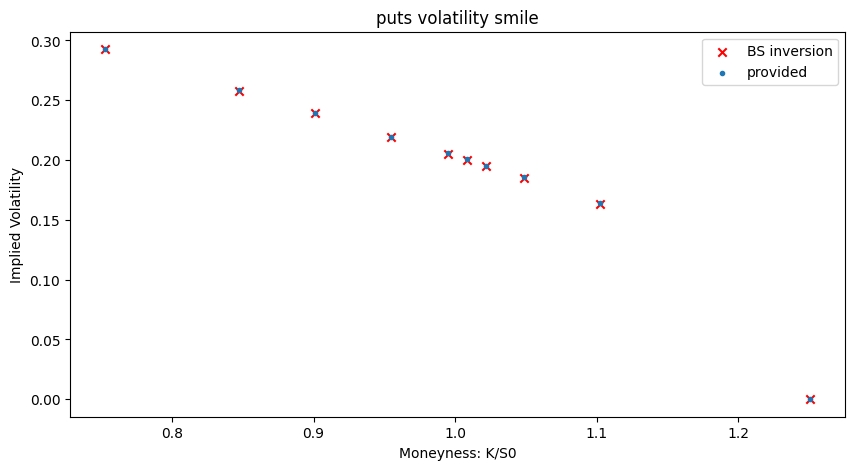

In [29]:
# Plot market implied volatilities w.r.t. log moneyness
x = (puts_strikes/S0)
# IV_filtered = [iv for iv in IV_market_p if iv != -1]
# x_filtered = [log_m for iv, log_m in zip(IV_market_p, x) if iv != -1]
IV_filtered = [iv for iv in IV_market if iv != -1]
x_filtered = [log_m for iv, log_m in zip(IV_market, x) if iv != -1]

fig, ax1 = plt.subplots(figsize=(10,5))

#puts
ax1.scatter(x, IV_market, marker='x', label='BS inversion', color='red')
ax1.scatter(x, puts['P_IV'], marker='.', label='provided')

ax1.set_xlabel('Moneyness: K/S0'); ax1.set_ylabel('Implied Volatility'); ax1.set_title('puts volatility smile')

ax1.legend(); plt.show()


In [30]:
otko_spx = pd.read_csv('data/otko_spx_1year.csv')

th_prices = pd.DataFrame({
    'K1': otko_spx['K1'],
    'K2': otko_spx['K2'],
    'Midpoint (%)': otko_spx['Midpoint (%)']
})
print(otko_spx)
th_mc_prices = pd.DataFrame({})
th_cf_prices = pd.DataFrame({})

otko_strikes = otko_spx[['K1', 'K2']].values / 100
otko_spreads =  otko_spx['ASK(%)'] - otko_spx['BID(%)']
otko_weights = 1/otko_spreads**2
otko_mkt_prices = otko_spx['Midpoint (%)'].values

  Starting date Stock Name Expiry  K1  K2  BID(%)  ASK(%)  Midpoint (%)
0    20/01/2016        SPX     1Y  75   0    0.17    0.20         0.185
1    20/01/2016        SPX     1Y  70   0    0.08    0.10         0.090
2    20/01/2016        SPX     1Y  85  75    0.34    0.40         0.370
3    20/01/2016        SPX     1Y  80  70    0.24    0.28         0.260
4    20/01/2016        SPX     1Y  90  80    0.48    0.54         0.510


### Option pricing calibration on the full set of options

#### Merton Jump Diffusion model

In [9]:
x0 = mert_params     # initial guess: [σ, λ, m, v]
bounds = ( [1e-3, 0, -2, 0], [2, 2, 0, 5] )

def cost_function(x, p_strikes, p_mkt_prices, o_strikes, o_mkt_prices):
    sigma, lambd, meanJ, stdJ = x
    M = Merton_pricer(S0, None, T, r, q, sigma, lambd, meanJ, stdJ, 'put')
    sq_err = np.sum( weights*(M.closed_formula_put(p_strikes) - p_mkt_prices)**2)
    for k in range(len(o_strikes)):
        sq_err +=  otko_weights[k]*(M.closed_formula_otko(o_strikes[k][0], o_strikes[k][1]) - o_mkt_prices[k])**2
    return sq_err

start = time.time()
mert = scpo.least_squares(cost_function, x0, args=(puts_strikes, puts_prices, otko_strikes, otko_mkt_prices), bounds=bounds, method = 'trf', verbose=2)
end = time.time()

mert_params_calibrated = [round(p,4) for p in mert.x[:4]]

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         7.2627e+07                                    5.02e+08    
       1              2         1.2176e+07      6.05e+07       7.37e-02       1.36e+08    
       2              3         1.6286e+06      1.05e+07       9.74e-02       1.45e+07    
       3              4         3.0850e+05      1.32e+06       4.31e-02       1.07e+07    
       4              6         2.2137e+05      8.71e+04       1.83e-02       1.86e+06    
       5              7         1.5966e+05      6.17e+04       7.40e-03       1.23e+06    
       6              8         8.7266e+04      7.24e+04       1.78e-02       6.78e+05    
       7              9         4.3982e+04      4.33e+04       3.05e-02       3.87e+06    
       8             11         3.3689e+04      1.03e+04       2.08e-02       2.79e+05    
       9             12         2.5993e+04      7.70e+03       7.54e-03       9.84e+04    

In [10]:
print('\nMETHOD: LEAST SQUARES (trf)')
print(f'> Calibrated Volatlity [σ] = {mert_params_calibrated[0]} \t {round(mert_params_calibrated[0]*100,2)}%')
print('> Calibrated Jump intensity [λ] = ', round(mert_params_calibrated[1],2))
print('> Calibrated Jump Mean = ', round(mert_params_calibrated[2],3))
print('> Calibrated Jump St. dev.  = ', round(mert_params_calibrated[3],3))
print(f'TIME ELAPSED:  {round(end-start,2)} sec')


METHOD: LEAST SQUARES (trf)
> Calibrated Volatlity [σ] = 0.2561 	 25.61%
> Calibrated Jump intensity [λ] =  0.31
> Calibrated Jump Mean =  -0.016
> Calibrated Jump St. dev.  =  0.199
TIME ELAPSED:  46.02 sec


In [20]:
print(mert_params_calibrated)

[0.2561, 0.3067, -0.0163, 0.1986]


#### Kou Jump Diffusion Model

In [12]:
x0 = kou_params     # initial guess: [σ, λ, p, η_1, η_2]
# x0 =[0.1447, 0.9, 0.7, 2.5685, 7.75]
bounds = ( [1e-3, 1e-2, 0, 0, 0], [1, 5, 0.9,  15, 20] )

# Define the objective function
def cost_function(x, p_strikes, p_mkt_prices, o_strikes, o_mkt_prices):
    sigm, lamb, p, eta1, eta2 = x
    KOU = Kou_pricer(S0=S0, K=p_strikes, ttm=T, r=r, sigma=sigm, lambd=lamb, p=p, eta1=eta1, eta2=eta2, exercise=exercise)
    sq_err = np.sum(weights*(KOU.closed_formula_put(p_strikes) - p_mkt_prices) ** 2)
    for k in range(len(o_strikes)):
        sq_err += otko_weights[k]*(KOU.closed_formula_otko(o_strikes[k][0], o_strikes[k][1]) - o_mkt_prices[k]) ** 2
    return sq_err

start2=time.time()
kou = scpo.least_squares(cost_function, x0, args=(puts_strikes, puts_prices, otko_strikes, otko_mkt_prices),  method='trf', bounds=bounds, verbose=2)
end2 =time.time()

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.0099e+06                                    1.89e+08    
       1              2         9.8004e+05      5.03e+06       5.51e-01       2.56e+07    
       2              4         6.9718e+05      2.83e+05       6.63e-02       2.09e+07    
       3              5         4.8747e+05      2.10e+05       9.10e-02       1.43e+07    
       4              6         2.3691e+05      2.51e+05       1.83e-01       6.87e+06    
       5              7         6.7006e+04      1.70e+05       3.88e-01       1.61e+06    
       6              8         2.8931e+04      3.81e+04       8.88e-01       6.22e+05    
       7              9         1.4903e+04      1.40e+04       5.96e-01       2.45e+05    
       8             12         1.4111e+04      7.92e+02       6.82e-02       4.80e+05    
       9             13         1.2030e+04      2.08e+03       7.38e-03       1.64e+05    

In [13]:
kou_params_calibrated = [round(p,4) for p in kou.x[:5]]

In [14]:
print('METHOD 2: Least-squares')
print(f'> Calibrated Volatlity [σ] = {round(kou_params_calibrated[0],4)} \t {round(kou_params_calibrated[0]*100,2)}%')
print('> Calibrated Jump intensity [λ] = ', round(kou_params_calibrated[1],2))
print(f'> Calibrated Upward Jump probability [p] = {round(kou_params_calibrated[2],2)}, [q] = {round(1-kou_params_calibrated[2],2)}')
print('> Calibrated Rate of Exp. 1  [η_1] = ', round(kou_params_calibrated[3],2))
print('> Calibrated Rate of Exp. 2  [η_2] = ', round(kou_params_calibrated[4],2))
print(f'TIME ELAPSED:  {round(end2-start2,2)} sec')

METHOD 2: Least-squares
> Calibrated Volatlity [σ] = 0.2583 	 25.83%
> Calibrated Jump intensity [λ] =  0.45
> Calibrated Upward Jump probability [p] = 0.6, [q] = 0.4
> Calibrated Rate of Exp. 1  [η_1] =  11.03
> Calibrated Rate of Exp. 2  [η_2] =  7.02
TIME ELAPSED:  2835.56 sec


In [21]:
print(kou_params_calibrated)

[0.2583, 0.4466, 0.5955, 11.0322, 7.0172]


#### Variance gamma model

In [16]:
x0 = vg_params
bounds = ( [1e-3, -3, 0], [1, 2, 10] )

def cost_function(x, p_strikes, p_mkt_prices, o_strikes, o_mkt_prices):
    sigma, theta, nu = x
    VG = VG_pricer(S0, None, T, r, q, sigma, theta, nu, exercise)
    prices = []
    for k in p_strikes:
        prices.append(VG.closed_formula_put(k))
    sq_err = np.sum(weights*(prices - p_mkt_prices)**2)
    for k in range(len(o_strikes)):
        sq_err += otko_weights[k]* (VG.closed_formula_otko6(o_strikes[k][0], o_strikes[k][1]) - o_mkt_prices[k]) ** 2
    return sq_err

start3=time.time()
vg = scpo.least_squares(cost_function, x0, args=(puts_strikes, puts_prices, otko_strikes, otko_mkt_prices),  method='trf', bounds=bounds, verbose=2)
end3=time.time()

vg_params_calibrated = [round(p,4) for p in vg.x[:3]]

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.2464e+06                                    4.84e+07    
       1              2         7.1118e+05      5.35e+05       1.80e+00       5.06e+07    
       2              5         1.3301e+05      5.78e+05       1.12e-01       8.69e+06    
       3              6         6.5425e+04      6.76e+04       2.25e-01       6.53e+05    
       4              9         6.2491e+04      2.93e+03       9.22e-03       1.27e+06    
       5             11         6.1279e+04      1.21e+03       3.58e-03       1.76e+05    
       6             12         6.0615e+04      6.63e+02       1.53e-03       1.37e+05    
       7             13         5.9655e+04      9.60e+02       3.37e-03       2.20e+05    
       8             15         5.9486e+04      1.70e+02       1.32e-03       9.23e+04    
       9             16         5.9323e+04      1.63e+02       1.03e-03       8.81e+04    

In [17]:
print('METHOD: LEAST-SQUARES (trf)')
print(f'> Calibrated Volatility [σ] = {vg_params_calibrated[0]}, \t {round(vg_params_calibrated[0]*100,2)}%')
print('> Calibrated mean rate gamma process [θ] = ', vg_params_calibrated[1])
print('> Calibrated variance rate gamma process [v]= ', vg_params_calibrated[2])
print(f'TIME ELAPSED:  {round(end3-start3,2)} sec')

METHOD: LEAST-SQUARES (trf)
> Calibrated Volatility [σ] = 0.2686, 	 26.86%
> Calibrated mean rate gamma process [θ] =  0.1661
> Calibrated variance rate gamma process [v]=  2.2582
TIME ELAPSED:  327.75 sec


In [31]:
print(vg_params_calibrated)

[0.2686, 0.1661, 2.2582]


### RESULTS FROM CALIBRATION
This section aims to reprice the options used for calibration. On this purpose, both calls and otko prices obtained by each model are compared to the original market prices, starting point of our calibration process.


In [33]:
days = 252
paths = 5000
#CALLS PRICES
puts_calib_prices = pd.DataFrame({
    'STRIKE': puts['STRIKE'],    # array of K for call options
    'MKT_BID': puts['P_BID'],
    'MKT_MID': puts['P_Midpoint'],
    'MKT_ASK': puts['P_ASK'],

})
print(f'MARKET PRICES. STARTING DATE = 20-01-2016. EXPIRY = 1YEAR. \n{puts_calib_prices}\n')

# OTKO PRICES
otko_calib_prices = pd.DataFrame({
    'K1': otko_spx['K1'],
    'K2': otko_spx['K2'],
    'MKT_BID (%)': otko_spx['BID(%)'],
    'MKT_MID (%)': otko_spx['Midpoint (%)'],
    'MKT_ASK (%)': otko_spx['ASK(%)']
})
print(f'MARKET PRICES. STARTING DATE = 20-01-2016. EXPIRY = 1YEAR. \n{otko_calib_prices}')

MARKET PRICES. STARTING DATE = 20-01-2016. EXPIRY = 1YEAR. 
   STRIKE  MKT_BID  MKT_MID  MKT_ASK
0  1400.0    45.50   46.695    47.89
1  1575.0    76.40   77.855    79.31
2  1675.0   101.59  103.090   104.59
3  1775.0   133.01  134.655   136.30
4  1850.0   162.39  164.140   165.89
5  1875.0   173.29  175.050   176.81
6  1900.0   184.89  186.700   188.51
7  1950.0   210.00  211.850   213.70
8  2050.0   268.89  270.945   273.00
9  2325.0   492.79  495.295   497.80

MARKET PRICES. STARTING DATE = 20-01-2016. EXPIRY = 1YEAR. 
   K1  K2  MKT_BID (%)  MKT_MID (%)  MKT_ASK (%)
0  75   0         0.17        0.185         0.20
1  70   0         0.08        0.090         0.10
2  85  75         0.34        0.370         0.40
3  80  70         0.24        0.260         0.28
4  90  80         0.48        0.510         0.54


#### Merton Jump Diffusion

CALIBRATED PARAMETERS [σ		λ		m		v]
> European puts:	 [0.1382, 0.6087, -0.0842, 0.357]
> OTKO DC:			 [0.1336, 0.1054, -0.1649, 0.1803]
> puts + OTKO:		 [0.2561, 0.3067, -0.0163, 0.1986]


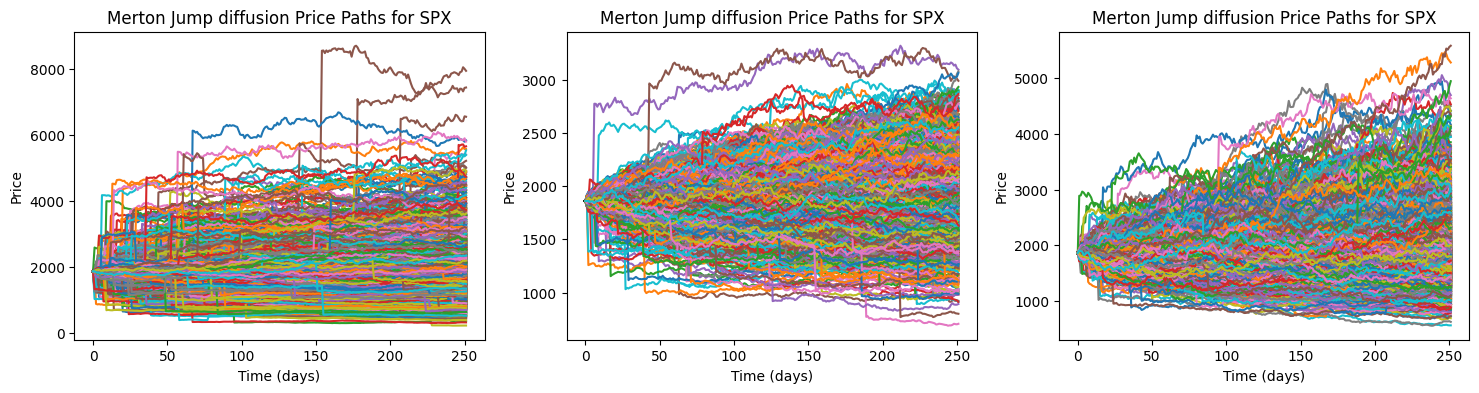

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

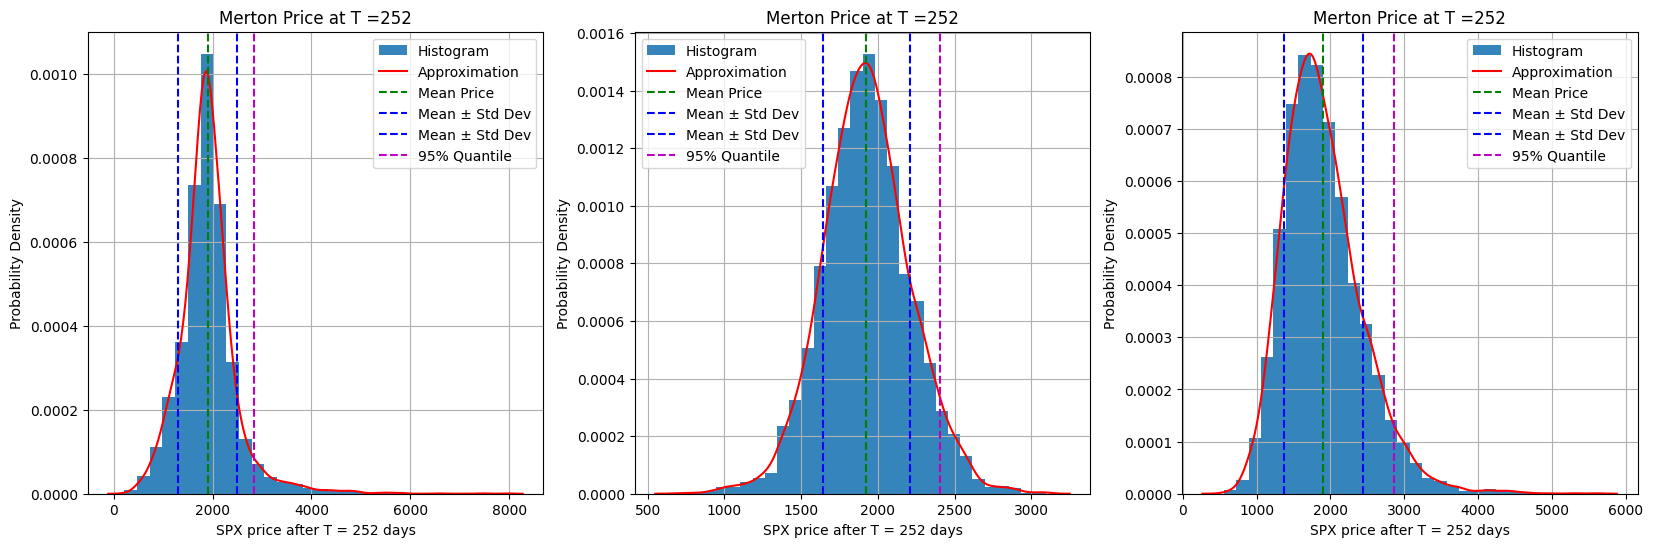

In [34]:
m_params_puts = [0.1382, 0.6087, -0.0842, 0.357]
m_params_otko = [0.1336, 0.1054, -0.1649, 0.1803]
m_params_mixed = mert_params_calibrated

print(f'CALIBRATED PARAMETERS [σ\t\tλ\t\tm\t\tv]')
print(f'> European puts:\t {m_params_puts}')
print(f'> OTKO DC:\t\t\t {m_params_otko}')
print(f'> puts + OTKO:\t\t {m_params_mixed}')

Merton1 = Merton_pricer(S0, None, T, r, q, m_params_puts[0], m_params_puts[1], m_params_puts[2], m_params_puts[3], exercise)
Merton2 = Merton_pricer(S0, None, T, r, q, m_params_otko[0], m_params_otko[1], m_params_otko[2], m_params_otko[3], exercise)
Merton3 = Merton_pricer(S0, None, T, r, q, m_params_mixed[0], m_params_mixed[1], m_params_mixed[2], m_params_mixed[3], exercise)

SMerton1 = Merton1.MertonPath(days, paths)
SMerton2 = Merton2.MertonPath(days, paths)
SMerton3 = Merton3.MertonPath(days, paths)

# PLOT MONTE CARLO PATHS
fig1, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,4))
Merton1.plotMertonPath(SMerton1, 'SPX', ax=axes[0])
Merton2.plotMertonPath(SMerton2, 'SPX', ax=axes[1])
Merton3.plotMertonPath(SMerton3, 'SPX', ax=axes[2])
plt.show()

# PLOT FINAL PRICE DISTRIBUTIONS
fig2, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
Merton1.plotMertonAtFixedTime(SMerton1, 251, 'SPX', ax = axes[0])
Merton2.plotMertonAtFixedTime(SMerton2, 251, 'SPX', ax = axes[1])
Merton3.plotMertonAtFixedTime(SMerton3, 251, 'SPX', ax = axes[2])

Then we show our options priced by the Merton model, using the parameters calibrated on the full set of European puts and One Touch Knockout Daily Cliquets.

In [35]:
avg_payoffs = []
for k in puts_strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for St in SMerton3[-1]:
        payoffs.append(Merton3.payoff_call(k, St))
    avg_payoffs.append(np.mean(payoffs))

merton_mc_prices = np.zeros(len(puts_calib_prices))
merton_cf_prices = np.zeros(len(puts_calib_prices))

for index in range(len(puts_calib_prices)):
    merton_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index]
    merton_cf_prices[index] = Merton3.closed_formula_put(puts_strikes[index])

puts_calib_prices['MERTON MC (%)'] = merton_mc_prices
puts_calib_prices['MERTON CF (%)'] = merton_cf_prices

avg_payoffs = []
for K1, K2 in otko_strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for path in SMerton3.T:
        payoffs.append(Merton3.payoff_otko(path, K1, K2))
    avg_payoffs.append(np.mean(payoffs))

merton_mc_prices = np.zeros(len(otko_calib_prices))
merton_cf_prices = np.zeros(len(otko_calib_prices))

for index in range(len(otko_calib_prices)):
    merton_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index] * 100
    merton_cf_prices[index] = Merton3.closed_formula_otko(otko_strikes[index][0], otko_strikes[index][1])

otko_calib_prices['MERTON MC (%)'] = merton_mc_prices
otko_calib_prices['MERTON CF (%)'] = merton_cf_prices

print(puts_calib_prices)
print('\n')
print(otko_calib_prices)

   STRIKE  MKT_BID  MKT_MID  MKT_ASK  MERTON MC (%)  MERTON CF (%)
0  1400.0    45.50   46.695    47.89     514.651651      28.720571
1  1575.0    76.40   77.855    79.31     381.936156      65.632892
2  1675.0   101.59  103.090   104.59     316.505550      96.816442
3  1775.0   133.01  134.655   136.30     259.478590     135.898532
4  1850.0   162.39  164.140   165.89     222.243653     170.398500
5  1875.0   173.29  175.050   176.81     210.787971     182.865667
6  1900.0   184.89  186.700   188.51     199.814715     195.805475
7  1950.0   210.00  211.850   213.70     179.325985     223.069978
8  2050.0   268.89  270.945   273.00     143.397149     282.864663
9  2325.0   492.79  495.295   497.80      75.287086     478.011188


   K1  K2  MKT_BID (%)  MKT_MID (%)  MKT_ASK (%)  MERTON MC (%)  MERTON CF (%)
0  75   0         0.17        0.185         0.20       0.142965       0.162146
1  70   0         0.08        0.090         0.10       0.068639       0.068731
2  85  75         0.34  

### Kou Jump Diffusion

CALIBRATED PARAMETERS: [σ		λ		p		η1		η2]
> European puts:	 [0.2193, 0.7222, 0.4273, 11.2726, 4.5653]
> OTKO DC:			 [0.1247, 0.4313, 0.5324, 10.3, 7.5159]
> puts + OTKO:		 [0.2583, 0.4466, 0.5955, 11.0322, 7.0172]


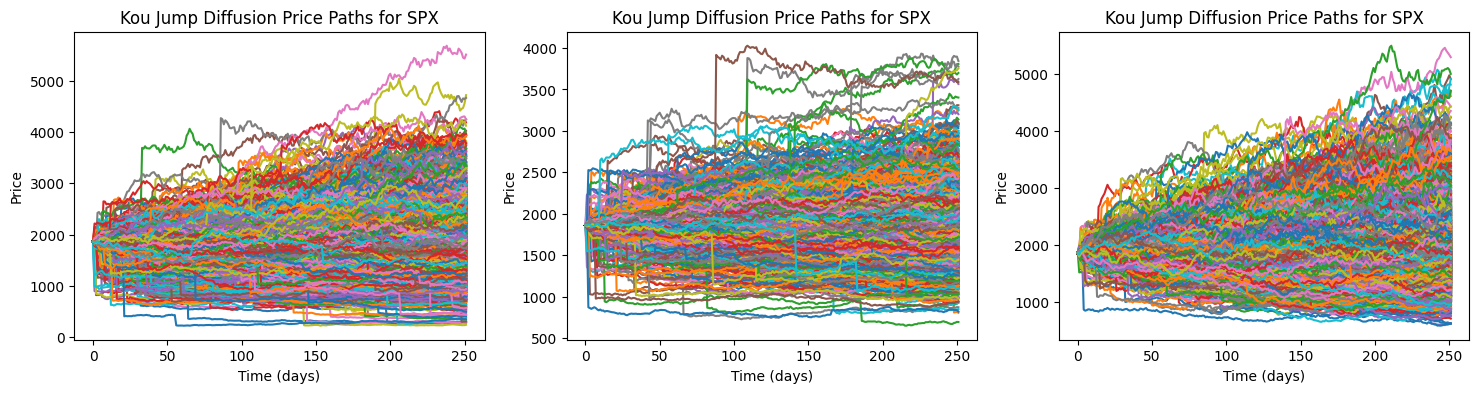

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

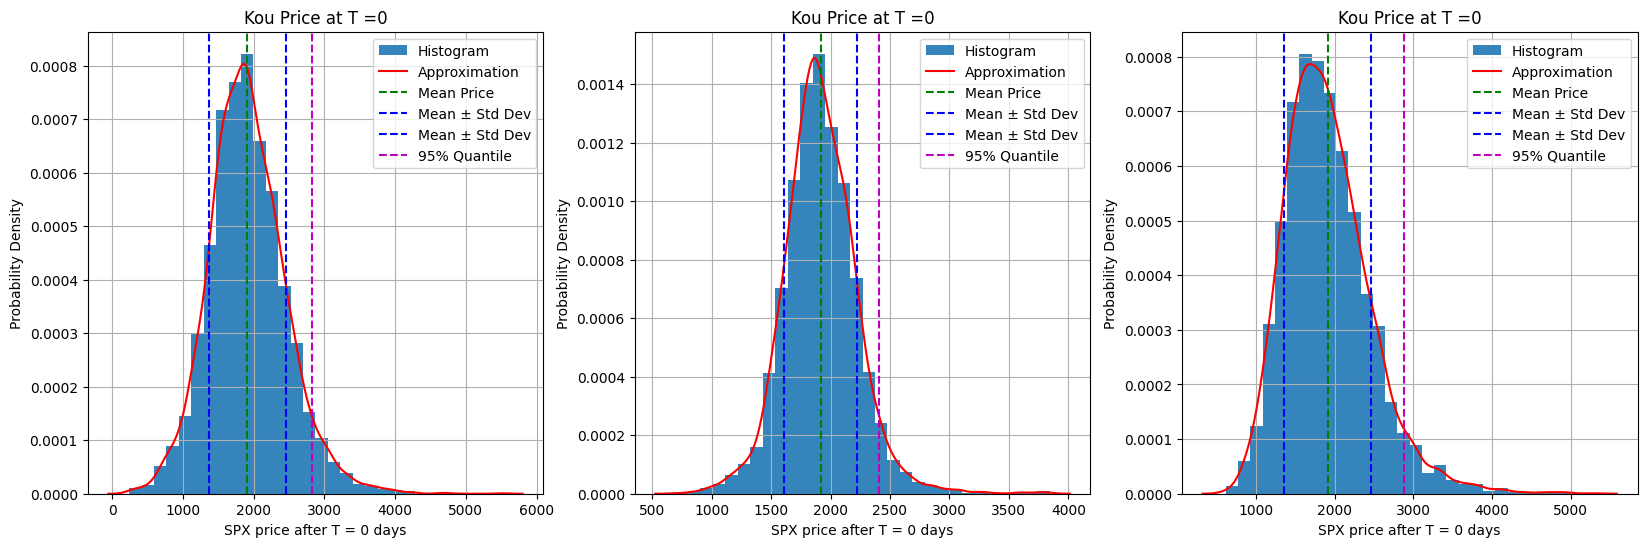

In [36]:
k_params_vanilla = [0.2193, 0.7222, 0.4273, 11.2726, 4.5653]
k_params_otko = [0.1247, 0.4313, 0.5324, 10.3, 7.5159]
k_params_mixed = kou_params_calibrated

print(f'CALIBRATED PARAMETERS: [σ\t\tλ\t\tp\t\tη1\t\tη2]')
print(f'> European puts:\t {k_params_vanilla}')
print(f'> OTKO DC:\t\t\t {k_params_otko}')
print(f'> puts + OTKO:\t\t {k_params_mixed}')

Kou1 = Kou_pricer(S0, None, T, r, k_params_vanilla[0], k_params_vanilla[1], k_params_vanilla[2], k_params_vanilla[3], k_params_vanilla[4], exercise)
Kou2 = Kou_pricer(S0, None, T, r, k_params_otko[0], k_params_otko[1], k_params_otko[2], k_params_otko[3], k_params_otko[4], exercise)
Kou3 = Kou_pricer(S0, None, T, r, k_params_mixed[0], k_params_mixed[1], k_params_mixed[2], k_params_mixed[3], k_params_mixed[4], exercise)

SKou1 = Kou1.KouPath(days, paths)
SKou2 = Kou2.KouPath(days, paths)
SKou3 = Kou3.KouPath(days, paths)

# PLOT MONTE CARLO PATHS
fig1, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,4))
Kou1.plotKouPath(SKou1, 'SPX', ax=axes[0])
Kou2.plotKouPath(SKou2, 'SPX', ax=axes[1])
Kou3.plotKouPath(SKou3, 'SPX', ax=axes[2])
plt.show()

# PLOT FINAL PRICE DISTRIBUTIONS
fig2, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
Kou1.plotKouAtFixedTime(SKou1, -1, 'SPX', ax = axes[0])
Kou2.plotKouAtFixedTime(SKou2, -1, 'SPX', ax = axes[1])
Kou3.plotKouAtFixedTime(SKou3, -1, 'SPX', ax = axes[2])

Compute the otko final prices for Kou model

In [39]:
avg_payoffs = []
for k in puts_strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for St in SKou3[-1]:
        payoffs.append(Kou3.payoff_put(k, St))
    avg_payoffs.append(np.mean(payoffs))

kou_mc_prices = np.zeros(len(puts_calib_prices))
kou_cf_prices = np.zeros(len(puts_calib_prices))

for index in range(len(puts_calib_prices)):
    kou_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index]
    kou_cf_prices[index] = Kou3.closed_formula_put(puts_strikes[index])

puts_calib_prices['KOU MC (%)'] = kou_mc_prices
puts_calib_prices['KOU CF (%)'] = kou_cf_prices

avg_payoffs = []
for K1, K2 in otko_strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for path in SKou3.T:
        payoffs.append(Kou3.payoff_otko(path, K1, K2))
    avg_payoffs.append(np.mean(payoffs))

kou_mc_prices = np.zeros(len(otko_calib_prices))
kou_cf_prices = np.zeros(len(otko_calib_prices))

for index in range(len(otko_calib_prices)):
    kou_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index] * 100
    kou_cf_prices[index] = Kou3.closed_formula_otko(otko_strikes[index][0], otko_strikes[index][1])

otko_calib_prices['KOU MC (%)'] = kou_mc_prices
otko_calib_prices['KOU CF (%)'] = kou_cf_prices

In [40]:
selection1 = [0,1,2,3,6,7]
print(f'>> PUTS\n{puts_calib_prices.iloc[:, selection1]}')
selection2 = [0,1,2,3,7,8]
print(f'\n>> OTKO\n{otko_calib_prices.iloc[:, selection2]}')

>> PUTS
   STRIKE  MKT_BID  MKT_MID  MKT_ASK  KOU MC (%)  KOU CF (%)
0  1400.0    45.50   46.695    47.89   30.417905   29.240532
1  1575.0    76.40   77.855    79.31   68.140352   66.068585
2  1675.0   101.59  103.090   104.59   99.866792   97.149035
3  1775.0   133.01  134.655   136.30  139.477465  136.095527
4  1850.0   162.39  164.140   165.89  173.967499  170.478642
5  1875.0   173.29  175.050   176.81  186.484036  182.904983
6  1900.0   184.89  186.700   188.51  199.493269  195.803364
7  1950.0   210.00  211.850   213.70  226.787039  222.984016
8  2050.0   268.89  270.945   273.00  286.668025  282.612503
9  2325.0   492.79  495.295   497.80  482.265042  477.386740

>> OTKO
   K1  K2  MKT_BID (%)  MKT_MID (%)  KOU MC (%)  KOU CF (%)
0  75   0         0.17        0.185    0.197816    0.203113
1  70   0         0.08        0.090    0.097180    0.116916
2  85  75         0.34        0.370    0.387548    0.350389
3  80  70         0.24        0.260    0.256864    0.223768
4  90  80   

#### Variance Gamma model

CALIBRATED PARAMETERS: [σ 		θ		 v]
> European puts:	 [0.2962, 0.0778, 0.6548]
> OTKO DC:			 [0.2566, 0.078, 1.6178]
> puts + OTKO:		 [0.2686, 0.1661, 2.2582]
CALIBRATED PARAMETERS: [μ_p	 μ_n	v_p	v_n]
> European puts:	 [0.301, 0.223, 0.059, 0.033]
> OTKO DC:			 [0.187, 0.109, 0.057, 0.019]
> puts + OTKO:		 [0.234, 0.068, 0.124, 0.01]


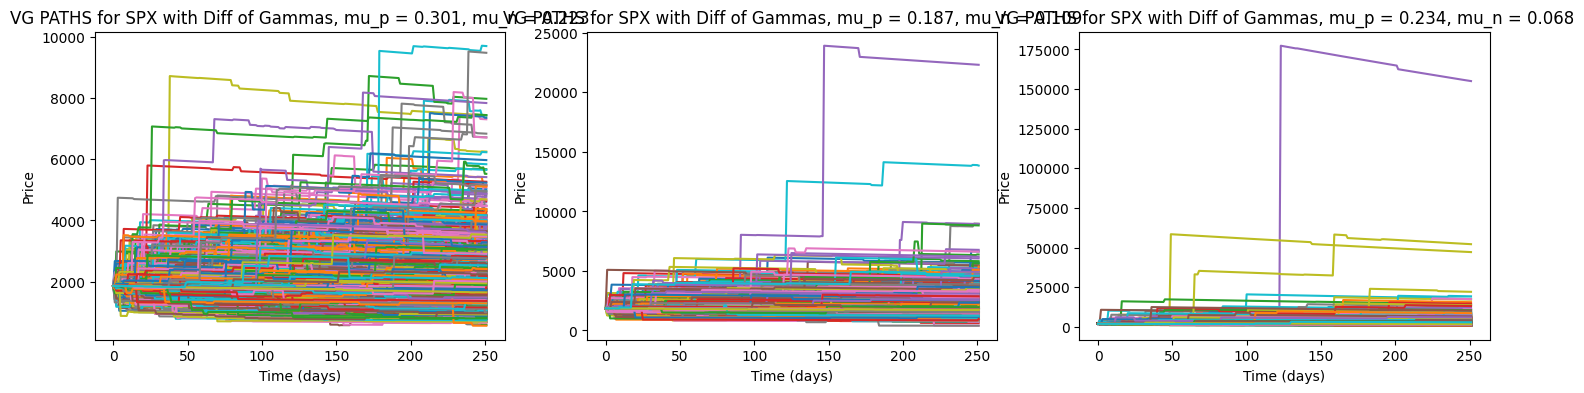

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

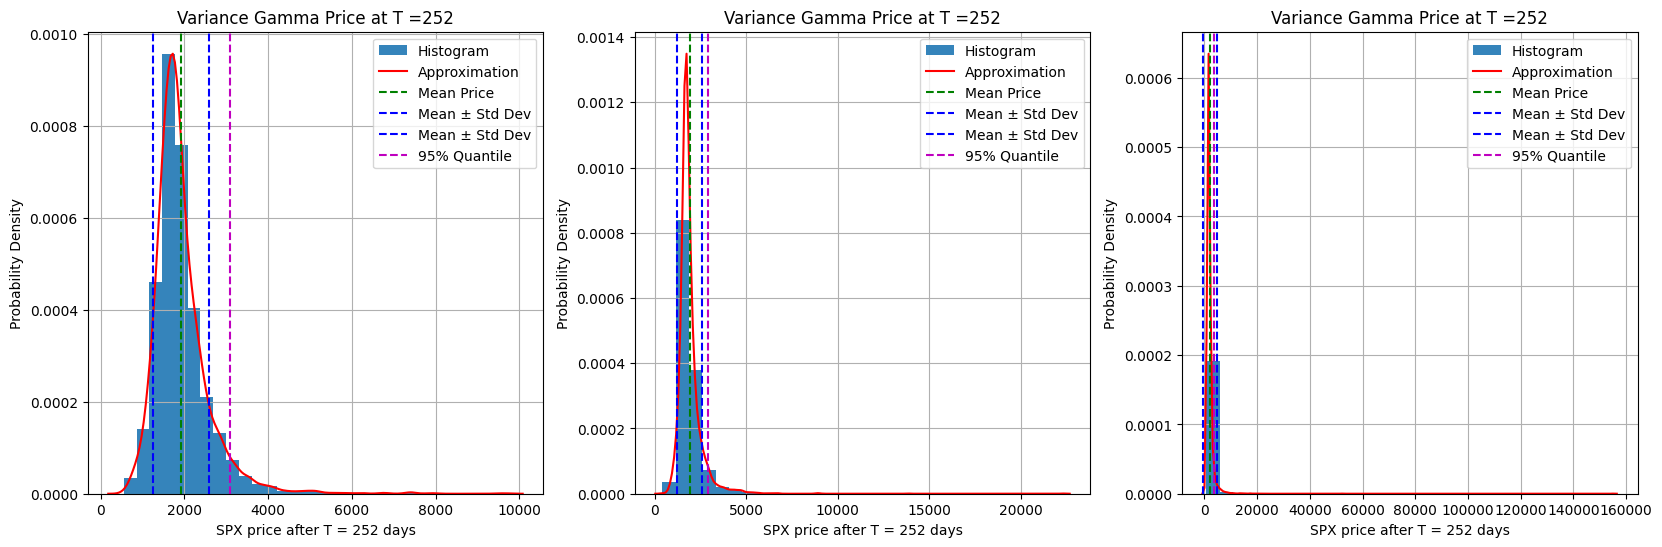

In [42]:
vg_params_puts = [0.2962, 0.0778, 0.6548]
vg_params_otko = [0.2566, 0.078, 1.6178]
vg_params_mixed = vg_params_calibrated
# vg_params_mixed = [0.2731, 0.3931, 0.1358]

VG1 = VG_pricer(S0, None, T, r, q, vg_params_puts[0], vg_params_puts[1], vg_params_puts[2],  exercise)
VG2 = VG_pricer(S0, None, T, r, q, vg_params_otko[0], vg_params_otko[1], vg_params_otko[2], exercise)
VG3 = VG_pricer(S0, None, T, r, q, vg_params_mixed[0], vg_params_mixed[1], vg_params_mixed[2], exercise)

print(f'CALIBRATED PARAMETERS: [σ \t\tθ\t\t v]')
print(f'> European puts:\t {vg_params_puts}')
print(f'> OTKO DC:\t\t\t {vg_params_otko}')
print(f'> puts + OTKO:\t\t {vg_params_mixed}')

vg_params_puts2 = [VG1.get_mu_p, VG1.get_mu_n, VG1.get_nu_p, VG1.get_nu_n]
vg_params_otko2 = [VG2.get_mu_p, VG2.get_mu_n, VG2.get_nu_p, VG2.get_nu_n]
vg_params_mixed2 = [VG3.get_mu_p, VG3.get_mu_n, VG3.get_nu_p, VG3.get_nu_n]

for i in range(len(vg_params_puts2)):
    vg_params_puts2[i] = round(vg_params_puts2[i], 3)
    vg_params_otko2[i] = round(vg_params_otko2[i], 3)
    vg_params_mixed2[i] = round(vg_params_mixed2[i], 3)

print(f'CALIBRATED PARAMETERS: [μ_p\t μ_n\tv_p\tv_n]')
print(f'> European puts:\t {vg_params_puts2}')
print(f'> OTKO DC:\t\t\t {vg_params_otko2}')
print(f'> puts + OTKO:\t\t {vg_params_mixed2}')

SVG1 = VG1.VarianceGammaPath1(days, paths)
SVG2 = VG2.VarianceGammaPath1(days, paths)
SVG3 = VG3.VarianceGammaPath1(days, paths)

# PLOT MONTE CARLO PATHS
fig1, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,4))
VG1.plotVGPath(SVG1, 'SPX', method='Diff of Gammas', ax=axes[0])
VG2.plotVGPath(SVG2, 'SPX',method='Diff of Gammas', ax=axes[1])
VG3.plotVGPath(SVG3, 'SPX', method='Diff of Gammas', ax=axes[2])
plt.tight_layout()
plt.show()


# PLOT FINAL PRICE DISTRIBUTIONS
fig2, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
VG1.plotVGAtFixedTime(SVG1, 251, 'SPX', ax = axes[0])
VG2.plotVGAtFixedTime(SVG2, 251, 'SPX', ax = axes[1])
VG3.plotVGAtFixedTime(SVG3, 251, 'SPX', ax = axes[2])

In [43]:
avg_payoffs = []
for k in puts_strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for St in SVG3[-1]:
        payoffs.append(VG3.payoff_put(k, St))
    avg_payoffs.append(np.mean(payoffs))

vg_mc_prices = np.zeros(len(puts_calib_prices))
vg_cf_prices = np.zeros(len(puts_calib_prices))

for index in range(len(puts_calib_prices)):
    vg_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index]
    vg_cf_prices[index] = VG3.closed_formula_put(puts_strikes[index])

puts_calib_prices['VG MC (%)'] = vg_mc_prices
puts_calib_prices['VG CF (%)'] = vg_cf_prices
avg_payoffs = []

for K1, K2 in otko_strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for path in SVG3.T:
        payoffs.append(VG3.payoff_otko(path, K1, K2))
    avg_payoffs.append(np.mean(payoffs))

vg_mc_prices = np.zeros(len(otko_calib_prices))
vg_cf_prices = np.zeros(len(otko_calib_prices))

for index in range(len(otko_calib_prices)):
    vg_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index] * 100
    vg_cf_prices[index] = VG3.closed_formula_otko5(otko_strikes[index][0], otko_strikes[index][1])

otko_calib_prices['VG MC (%)'] = vg_mc_prices
otko_calib_prices['VG CF (%)'] = vg_cf_prices

In [44]:
selection1 = [0,1,2,3,8,9]
print(f'>> CALLS\n{puts_calib_prices.iloc[:, selection1]}')
selection2 = [0,1,2,3,9,10]
print(f'\n>> OTKO\n{otko_calib_prices.iloc[:, selection2]}')

>> CALLS
   STRIKE  MKT_BID  MKT_MID  MKT_ASK   VG MC (%)   VG CF (%)
0  1400.0    45.50   46.695    47.89   21.800928   60.135243
1  1575.0    76.40   77.855    79.31   84.801256   90.609463
2  1675.0   101.59  103.090   104.59  141.734191  112.838144
3  1775.0   133.01  134.655   136.30  206.586532  139.352731
4  1850.0   162.39  164.140   165.89  258.557420  162.554107
5  1875.0   173.29  175.050   176.81  276.404961  171.007480
6  1900.0   184.89  186.700   188.51  294.488842  179.854512
7  1950.0   210.00  211.850   213.70  331.335571  198.828402
8  2050.0   268.89  270.945   273.00  407.535825  242.827279
9  2325.0   492.79  495.295   497.80  629.448792  435.239709

>> OTKO
   K1  K2  MKT_BID (%)  MKT_MID (%)  VG MC (%)  VG CF (%)
0  75   0         0.17        0.185   0.155940   0.197640
1  70   0         0.08        0.090   0.071763   0.103625
2  85  75         0.34        0.370   0.458065   0.479923
3  80  70         0.24        0.260   0.249461   0.265838
4  90  80         0.4